# MODFLOW Tutorial 1: Confined Steady-State Flow Model

This tutorial demonstrates use of FloPy to develop a simple MODFLOW-2005 model.

## Getting Started

If FloPy has been properly installed, then it can be imported as follows:

In [1]:
import numpy as np

In [2]:
import flopy

Now that we can import flopy, we begin creating our simple MODFLOW model. numpy is imported to create arrays of model data.

# Creating the MODFLOW Model

One of the nice things about creating models in python is that it is very easy to change one or two things and completely change the grid resolution for your model. So in this example, we will design our python script so that the number of layers, columns, and rows can be easily changed.

We can create a very simple MODFLOW model that has a basic package (BAS), discretization input file (DIS), layer-property flow (LPF) package, output control (OC), and preconditioned conjugate gradient (PCG) solver. Each one of these has its own input file, which will be created automatically by flopy, provided that we pass flopy the correct information.

## Discretization

We start by creating our flopy model object.

In [3]:
modelname = "tutorial1_mf"
mf = flopy.modflow.Modflow(modelname, exe_name="mf2005")

Next, let’s proceed by defining our model domain and creating a MODFLOW grid to span the domain.

In [4]:
Lx = 1000.0
Ly = 1000.0
ztop = 0.0
zbot = -50.0
nlay = 1
nrow = 10
ncol = 10
delr = Lx / ncol
delc = Ly / nrow
delv = (ztop - zbot) / nlay
botm = np.linspace(ztop, zbot, nlay + 1)

With this information, we can now create the flopy discretization object by entering the following:

In [5]:
dis = flopy.modflow.ModflowDis(
    mf, nlay, nrow, ncol, delr=delr, delc=delc, top=ztop, botm=botm[1:]
)

## Basic Package

Next we can create a flopy object that represents the MODFLOW Basic Package. For this simple model, we will assign constant head values of 10. and 0. to the first and last model columns (in all layers), respectively. The python code for doing this is:

In [6]:
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)
ibound[:, :, 0] = -1
ibound[:, :, -1] = -1
strt = np.ones((nlay, nrow, ncol), dtype=np.float32)
strt[:, :, 0] = 10.0
strt[:, :, -1] = 0.0
bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)

## Layer-Property Flow Package

Constant values of 10. are assigned for the horizontal and vertical hydraulic conductivity:

In [7]:
lpf = flopy.modflow.ModflowLpf(mf, hk=10.0, vka=10.0, ipakcb=53)

Because we did not specify a value for laytyp, Flopy will use the default value of 0, which means that this model will be confined.

## Output Control

Here we can use the default OC settings by specifying the following:

In [8]:
spd = {(0, 0): ["print head", "print budget", "save head", "save budget"]}
oc = flopy.modflow.ModflowOc(mf, stress_period_data=spd, compact=True)

The stress period dictionary is used to set what output is saved for the corresponding stress period and time step. In this case, the tuple (0, 0) means that stress period 1 and time step 1 for MODFLOW will have output saved. Head and budgets will be printed and head and budget information will be saved

# Preconditioned Conjugate Gradient Package

The default settings used by flopy will be used by specifying the following commands:

In [9]:
pcg = flopy.modflow.ModflowPcg(mf)

## Writing the MODFLOW Data Files

The MODFLOW input data files are written by simply issuing the following:

In [10]:
mf.write_input()

## Running the Model

Flopy can also be used to run the model. The model object (mf in this example) has an attached method that will run the model. For this to work, the MODFLOW program must be located somewhere within the system path, or within the working directory. In this example, we have specified that the name of the executable program is ‘mf2005’. Issue the following to run the model:

In [11]:
success, buff = mf.run_model()
if not success:
    raise Exception("MODFLOW did not terminate normally.")

FloPy is using the following executable to run the model: ..\..\..\..\..\..\002 Modflow-PEST\mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: tutorial1_mf.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2024/03/21  6:44:04

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2024/03/21  6:44:04
 Elapsed run time:  0.005 Seconds

  Normal termination of simulation


Here we have used run_model, and we could also have specified values for the optional keywords silent, pause, and report.

### Post-Processing the Results

Now that we have successfully built and run our MODFLOW model, we can look at the results. MODFLOW writes the simulated heads to a binary data output file. We cannot look at these heads with a text editor, but flopy has a binary utility that can be used to read the heads. The following statements will read the binary head file and create a plot of simulated heads for layer 1:

In [12]:
import matplotlib.pyplot as plt

In [13]:
import flopy.utils.binaryfile as bf

##### Extract the heads

In [14]:
hds = bf.HeadFile(f"{modelname}.hds")
head = hds.get_data(totim=1.0)

##### Contour the heads

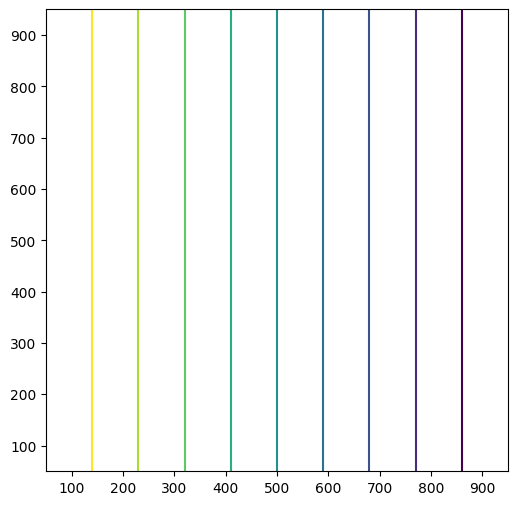

In [15]:
extent = (delr / 2.0, Lx - delr / 2.0, Ly - delc / 2.0, delc / 2.0)
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
ax.contour(head[0, :, :], levels=np.arange(1, 10, 1), extent=extent)

Flopy also has some pre-canned plotting capabilities can can be accessed using the PlotMapView() class. The following code shows how to use the plotmapview class to plot boundary conditions (IBOUND), plot the grid, plot head contours, and plot vectors:

In [16]:
# Extract the heads
hds = bf.HeadFile(f"{modelname}.hds")
times = hds.get_times()
head = hds.get_data(totim=times[-1])

##### Extract the cell-by-cell flows

In [17]:
cbb = bf.CellBudgetFile(f"{modelname}.cbc")
kstpkper_list = cbb.get_kstpkper()
frf = cbb.get_data(text="FLOW RIGHT FACE", totim=times[-1])[0]
fff = cbb.get_data(text="FLOW FRONT FACE", totim=times[-1])[0]
qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(
    (frf, fff, None), mf, head
)

###### Create the figure

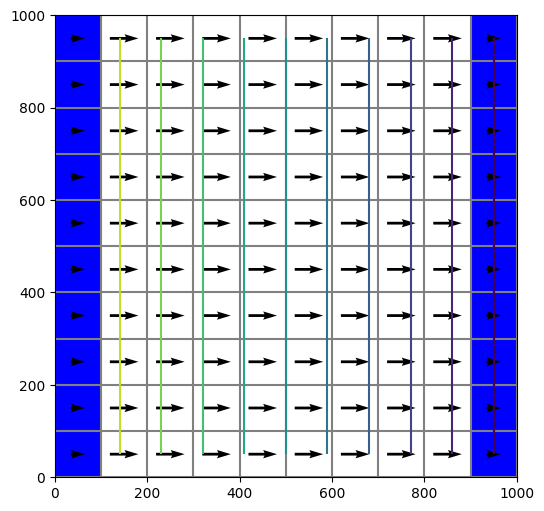

In [18]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
modelmap = flopy.plot.PlotMapView(model=mf, layer=0, ax=ax)
qm = modelmap.plot_ibound()
lc = modelmap.plot_grid()
cs = modelmap.contour_array(head, levels=np.linspace(0, 10, 11))
quiver = modelmap.plot_vector(qx, qy)